In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import multilabel_confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import randint, uniform
import catboost as cb
import math
from imblearn.over_sampling import SMOTE, SVMSMOTE, KMeansSMOTE
from boruta import BorutaPy
from BorutaShap import BorutaShap

import shap

from shap_selection import feature_selection
shap.initjs()

pd.set_option('display.max_columns', 70)
pd.set_option('display.max_colwidth', None) #100 or None

os.getcwd()

'/Users/miek/Documents/DS4B/DS4BThesisSNCB'

In [3]:
# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_parquet("~/Downloads/justif_parquet")
justifs = justifs[justifs['TRAIN_ID_resp'].notna()]
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)

# duplicate columns of interest to update with info from the train that was ultimately responsable for the knock-on delay
justifs['justification_dt_originator'] = justifs['justification_dt']
justifs['trno_resp_originator'] = justifs['trno_resp']
justifs['TRAIN_ID_resp_originator'] = justifs['TRAIN_ID_resp']


## Getting the label - preparation: we transform justifs to account for knock-on delays

In [4]:
# check potential overlap (in reality can be even more as uniqueness is not required)

unique_impacted = pd.unique(justifs['REF_TOD_IMPACTED_TRAIN'])
unique_responsible_originator = pd.unique(justifs['TRAIN_ID_resp_originator'])
print(len(unique_impacted)) # 293355
print(len(unique_responsible_originator)) # 268046
#common_elements = [element for element in unique_responsible_originator if element in unique_impacted] # takes a minute
#print(len(common_elements)) # 112818

293355
268046


In [ ]:
justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'justification_dt',
         'trno_resp', 'TRAIN_ID_resp', 'justification_dt_originator', 'trno_resp_originator', 'TRAIN_ID_resp_originator']]

,DEPARTURE_DT,TRAIN_NUMBER,REF_TOD_IMPACTED_TRAIN,JUSTIFIED_DIFFERENTIAL_DELAY,justification_dt,trno_resp,TRAIN_ID_resp,justification_dt_originator,trno_resp_originator,TRAIN_ID_resp_originator
0,2019-09-26,1707,24192376,2,2019-09-26 09:01:51,7574.0,24196802.0,2019-09-26 09:01:51,7574.0,24196802.0
1,2020-01-07,9251,24786498,2,2020-01-07 15:50:04,8600.0,24788833.0,2020-01-07 15:50:04,8600.0,24788833.0
2,2019-02-25,1528,22936396,2,2019-02-25 07:36:39,7054.0,22940978.0,2019-02-25 07:36:39,7054.0,22940978.0
3,2019-03-18,2304,23057298,2,2019-03-18 07:28:47,7006.0,23058491.0,2019-03-18 07:28:47,7006.0,23058491.0
4,2019-09-05,437,24062554,2,2019-09-05 16:39:22,8801.0,24065964.0,2019-09-05 16:39:22,8801.0,24065964.0
...,...,...,...,...,...,...,...,...,...,...
724219,2022-05-02,565,30224546,2,2022-05-02 18:04:11,8972.0,30222279.0,2022-05-02 18:04:11,8972.0,30222279.0
724220,2022-03-29,7362,29999779,1,2022-03-29 08:43:07,2855.0,30001588.0,2022-03-29 08:43:07,2855.0,30001588.0
724221,2022-03-29,507,30001637,1,2022-03-29 12:42:07,7009.0,30000162.0,2022-03-29 12:42:07,7009.0,30000162.0
724225,2022-04-11,3919,30084539,9,2022-04-11 19:32:11,8766.0,30083107.0,2022-04-11 19:32:11,8766.0,30083107.0


In [ ]:
# Add priors column to keep track of how many times a row has been updated
justifs["priors"] = 0


# Loop through each row
for i, row in justifs.iterrows():
    # Get the initial row justification_dt, trno_resp, and TRAIN_ID_resp
    initial_dt = row["justification_dt_originator"]
    initial_trno = row["trno_resp_originator"]
    initial_train_id = row["TRAIN_ID_resp_originator"]
    priors = 0
    
    # Look for a prior row
    # Set flag to True initially to enter the while loop
    has_prior_row = True
    
    while has_prior_row:
        prior_row = justifs[(justifs["REF_TOD_IMPACTED_TRAIN"] == initial_train_id) & 
                      (justifs["justification_dt"] < initial_dt) & 
                      (justifs["justification_dt"] >= initial_dt - timedelta(minutes=5))]
        
        # If a prior row exists, update the initial row with its values
        if not prior_row.empty:
            prior_row = prior_row.iloc[-1]  # Get the most recent prior row
            justifs.at[i, "justification_dt_originator"] = prior_row["justification_dt"]
            justifs.at[i, "trno_resp_originator"] = prior_row["trno_resp"]
            justifs.at[i, "TRAIN_ID_resp_originator"] = prior_row["TRAIN_ID_resp"]
            priors += 1
            initial_dt = prior_row["justification_dt"]
            initial_trno = prior_row["trno_resp"]
            initial_train_id = prior_row["TRAIN_ID_resp"]
        else:
            has_prior_row = False
            
    # Update priors column for the current row
    justifs.at[i, "priors"] = priors

# check
justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'justification_dt',
         'trno_resp', 'TRAIN_ID_resp', 'justification_dt_originator', 'trno_resp_originator', 'TRAIN_ID_resp_originator', 'priors']]

,REF_JUS_ID,IMPACTED_TRAIN_DEPARTURE_DT,IMPACTED_TRAIN_LABEL,REF_TOD_IMPACTED_TRAIN,PTCAR_NO,DISTURBANCE_DT,JUSTIFIED_DIFFERENTIAL_DELAY,DISTURBANCE_ID,REF_DOSSIER,REF_JUSTIFICATION_NO,DemandJustifyType,TRAIN_NUMBER,NAT_RGE,DEPARTURE_DT,PassengerTrain,REF_OPE_NO,COMMERCIAL_TYPE,LONG_NAME_NL,LONG_NAME_FR,GPS_LATITUDE,GPS_LONGITUDE,DISTRICT_ID,DISTURB_TYPE_ID,type_fr,type_nl,groupe_fr,groupe_nl,TRAIN_ID_resp,Libelle_resp,trno_resp,nat_rge_resp,RSP_NB,rsp_nb2,Disturb_id2,DOSSIER_NO,dossier_type2,master_dossier_ref2,ELEMENT,REPORT,DATUM,type_fr2,type_nl2,groupe_fr2,groupe_nl2,justification_dt,DOSSIER_REF,PTR_PTCAR_NO,LIN_LIGN_ID,REF_LINE_NO,LINE_NUMBER,IDENTIFICATOR,p_resp,justification_dt_originator,trno_resp_originator,TRAIN_ID_resp_originator,priors
0,26460201,2019-09-26,E1707,24192376,215,2019-09-26 09:01:51,2,29864904,0,18574998,Delay,1707,,2019-09-26,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24196802.0,7574,7574.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-09-26 09:01:51,NaN,NaN,NaN,NaN,NaN,None,1,2019-09-26 09:01:51,7574.0,24196802.0,0
1,27027204,2020-01-07,EE9251,24786498,215,2020-01-07 15:50:03,2,30965100,0,19303584,Delay,9251,,2020-01-07,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24788833.0,8600,8600.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2020-01-07 15:50:04,NaN,NaN,NaN,NaN,NaN,None,1,2020-01-07 15:46:26,1714.0,24786950.0,1
2,25381769,2019-02-25,EE1528,22936396,136,2019-02-25 07:36:38,2,27776562,0,17190058,Delay,1528,,2019-02-25,1:train with passengers,SNCB/NMBS,IC,BELLEM,BELLEM,51.083908,3.487367,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,22940978.0,7054,7054.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-02-25 07:36:39,NaN,NaN,NaN,NaN,NaN,None,1,2019-02-25 07:36:39,7054.0,22940978.0,0
3,25492144,2019-03-18,E2304,23057298,215,2019-03-18 07:28:47,2,27992088,0,17334611,Delay,2304,,2019-03-18,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,23058491.0,7006,7006.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-03-18 07:28:47,NaN,NaN,NaN,NaN,NaN,None,1,2019-03-18 07:28:47,7006.0,23058491.0,0
4,26343649,2019-09-05,EE437,24062554,215,2019-09-05 16:39:22,2,29641904,0,18427906,Delay,437,,2019-09-05,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24065964.0,8801,8801.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-09-05 16:39:22,NaN,NaN,NaN,NaN,NaN,None,1,2019-09-05 16:39:22,8801.0,24065964.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724219,31323710,2022-05-02,E565,30224546,878,2022-05-02 16:40:56,2,39472740,39465312,24591301,Delay,565,,2022-05-02,1:train with passengers,SNCB/NMBS,L,Y.MELLE-WEST,Y.MELLE-WEST,51.006636,3.790668,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,30222279.0,8972,8972.0,,None,2222082,39465312.0,30/CD4/4018006/122/22,Master,NaN,Z52904: VASTE REM HG HKM,&lt;p&gt;defect wagen 52904 Sinaai Defect Z529...,2022-05-02 09:43:00,avarie wagon,averij wagen,SO - Gesleept Materieel,EF - Matériel tracté,2022-05-02 18:04:11,143025942.0,1088.0,590.0,590.0,59.0,59,1,2022-05-02 18:04:11,8972.0,30222279.0,0
724220,31080409,2022-03-29,E7362,29999779,1548,2022-03-29 07:07:28,1,38997370,38995828,24309434,Delay,7362,,2022-03-29,1:train with passenge

In [85]:
print(round((justifs['priors'].value_counts(normalize=True)*100),3))

priors
0    84.967
1    12.866
2     1.655
3     0.398
4     0.088
5     0.020
6     0.004
7     0.001
8     0.000
Name: proportion, dtype: float64


In [1051]:
justifs[['trno_resp', 'trno_resp_originator', 'p_resp_originator']] # check

,trno_resp,trno_resp_originator,p_resp_originator
index,,,
0,7574.0,7574.0,1
1,8600.0,1714.0,0
2,7054.0,7054.0,1
3,7006.0,7006.0,1
4,8801.0,8801.0,1
...,...,...,...
724219,8972.0,8972.0,1
724220,2855.0,2855.0,0
724221,7009.0,2807.0,0


In [1061]:
print(justifs['p_resp'].value_counts(normalize=True)*100)
justifs['p_resp'].value_counts()

p_resp
1    58.608975
0    41.391025
Name: proportion, dtype: float64


p_resp
1    310011
0    218937
Name: count, dtype: int64

In [1060]:
print(justifs['p_resp_originator'].value_counts(normalize=True)*100)
justifs['p_resp_originator'].value_counts()

p_resp_originator
1    50.47982
0    49.52018
Name: proportion, dtype: float64


p_resp_originator
1    267012
0    261936
Name: count, dtype: int64

In [64]:
justifs['p_resp_originator'] = justifs['trno_resp_originator'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)
justifs[['trno_resp', 'trno_resp_originator', 'p_resp_originator']] # check

justifs['p_resp_originator'].value_counts(normalize=True)*100
justifs[justifs['p_resp']==1]['p_resp_originator'].value_counts(normalize=True)

p_resp_originator
1    0.832035
0    0.167965
Name: proportion, dtype: float64

In [74]:
# make p_resp_situation column
# 0 = no P train responsible
# 1 = P train is first responsible
# 2 = P train delayed other P-train is responsible
justifs['p_resp_situation'] = 0

mask = (justifs['trno_resp_originator'].between(7000, 8999)) & (justifs['trno_resp'].between(7000, 8999))
justifs.loc[mask, 'p_resp_situation'] = 1

different_numbers_mask = (justifs['trno_resp_originator'] != justifs['trno_resp'])
justifs.loc[mask & different_numbers_mask, 'p_resp_situation'] = 2

# check
#justifs['p_resp_situation'].value_counts(normalize=True)
justifs[justifs['p_resp']==1]['p_resp_situation'].value_counts(normalize=True)


p_resp_situation
1    0.794736
0    0.167965
2    0.037299
Name: proportion, dtype: float64

In [62]:
justifs['priors'].value_counts(normalize=True)

priors
0    0.849668
1    0.128663
2    0.016548
3    0.003981
4    0.000885
5    0.000202
6    0.000042
7    0.000008
8    0.000004
Name: proportion, dtype: float64

In [6]:
# save file
#justifs.to_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

# read file
#justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

In [4]:
justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

## Getting the label - Creation: we join transformed justifs to punctuality data, then group by responsible P-train.
We assign the positive label (1) if any of the trains impacted by the P-train failed to meet the service level for punctuality (>= 6m delay)

In [8]:
# label dataframe
# join to get punctuality of impacted trains
punct_justifs = all_punct.merge(justifs, left_on='TRAIN_ID', right_on='REF_TOD_IMPACTED_TRAIN', how = 'left')
punct_justifs = punct_justifs[(punct_justifs['trno_resp_originator'] >= 7000) & (punct_justifs['trno_resp_originator'] <= 8999)].drop(columns='index').reset_index()

# get label for p-trains: how many trains did they impact and how many were on time
punct_justifs_grouped = punct_justifs.groupby(['DAT_DEP', 'TRAIN_ID_resp_originator', 'trno_resp_originator']).agg(count_impacted=('REF_TOD_IMPACTED_TRAIN', 'size'),
                                                                                                                   count_impacted_ontime=('Retard_1pointage_valeur', 'sum')).reset_index()
punct_justifs_grouped['service_level'] = punct_justifs_grouped['count_impacted_ontime'] / punct_justifs_grouped['count_impacted']
punct_justifs_grouped['label'] = punct_justifs_grouped['service_level'].apply(lambda x: 1 if x < 1 else 0) # as soon as 1 impacted train is late, we assign label 1            (alt: if 90% of impacted trains are still on time we assign positve label)

punct_justifs_grouped

,DAT_DEP,TRAIN_ID_resp_originator,trno_resp_originator,count_impacted,count_impacted_ontime,service_level,label
0,1/01/2020,24759460.0,7672.0,1,1.0,1.000000,0
1,1/02/2019,22800231.0,8973.0,1,1.0,1.000000,0
2,1/02/2019,22800253.0,7012.0,3,2.0,0.666667,1
3,1/02/2019,22800254.0,7600.0,3,3.0,1.000000,0
4,1/02/2019,22800322.0,8293.0,1,1.0,1.000000,0
...,...,...,...,...,...,...,...
105991,9/12/2022,31634483.0,8960.0,2,0.0,0.000000,1
105992,9/12/2022,31634832.0,8975.0,2,1.0,0.500000,1
105993,9/12/2022,31634834.0,8974.0,2,2.0,1.000000,0
105994,9/12/2022,31634879.0,7305.0,1,0.0,0.000000,1


In [9]:
punct_justifs_grouped['count_impacted_delayed'] = punct_justifs_grouped['count_impacted'] - punct_justifs_grouped['count_impacted_ontime']
punct_justifs_grouped

,DAT_DEP,TRAIN_ID_resp_originator,trno_resp_originator,count_impacted,count_impacted_ontime,service_level,label,count_impacted_delayed
0,1/01/2020,24759460.0,7672.0,1,1.0,1.000000,0,0.0
1,1/02/2019,22800231.0,8973.0,1,1.0,1.000000,0,0.0
2,1/02/2019,22800253.0,7012.0,3,2.0,0.666667,1,1.0
3,1/02/2019,22800254.0,7600.0,3,3.0,1.000000,0,0.0
4,1/02/2019,22800322.0,8293.0,1,1.0,1.000000,0,0.0
...,...,...,...,...,...,...,...,...
105991,9/12/2022,31634483.0,8960.0,2,0.0,0.000000,1,2.0
105992,9/12/2022,31634832.0,8975.0,2,1.0,0.500000,1,1.0
105993,9/12/2022,31634834.0,8974.0,2,2.0,1.000000,0,0.0
105994,9/12/2022,31634879.0,7305.0,1,0.0,0.000000,1,1.0


In [23]:
# check characteristics of train_numbers
punct_justifs_grouped_trno = punct_justifs_grouped.groupby(['trno_resp_originator']).agg(
    n_rides = ('trno_resp_originator', 'size'),
    n_count_impacted = ('count_impacted', 'size'),
    mean_count_impacted = ('count_impacted', 'mean'),
    mean_count_impacted_ontime = ('count_impacted_ontime', 'mean'),
    mean_service_level = ('service_level', 'mean'),
    mean_count_impacted_delayed = ('count_impacted_delayed', 'mean')).reset_index()

punct_justifs_grouped_trno['delay_perc'] = 1 - punct_justifs_grouped_trno['mean_service_level']

punct_justifs_grouped_trno[punct_justifs_grouped_trno['n_rides'] > 5].sort_values(by='delay_perc', ascending=False)

,trno_resp_originator,n_rides,n_count_impacted,mean_count_impacted,mean_count_impacted_ontime,mean_service_level,mean_count_impacted_delayed,delay_perc
473,8692.0,11,11,1.636364,0.272727,0.121212,1.363636,0.878788
129,7596.0,16,16,1.375000,0.187500,0.187500,1.187500,0.812500
557,8976.0,32,32,1.437500,0.187500,0.187500,1.250000,0.812500
285,7983.0,13,13,1.076923,0.230769,0.230769,0.846154,0.769231
133,7603.0,17,17,3.000000,0.294118,0.254902,2.705882,0.745098
...,...,...,...,...,...,...,...,...
22,7066.0,207,207,1.280193,1.115942,0.927536,0.164251,0.072464
322,8067.0,69,69,1.333333,1.144928,0.942029,0.188406,0.057971
273,7970.0,350,350,1.348571,1.260000,0.956056,0.088571,0.043944
323,8073.0,394,394,1.317259,1.230964,0.956853,0.086294,0.043147


In [26]:
# rows dataframe
#
p_trains = all_punct[(all_punct['TRAIN_NUMBER']  >= 7000) & (all_punct['TRAIN_NUMBER'] <= 8999)].reset_index().drop(columns=['level_0', 'index'])
p_trains

,TRAIN_ID,DAT_DEP,Retard_1pointage,PTCAR_1pointage,Retard_2pointage,PTCAR_2pointage,NAT_RGE,TRAIN_NUMBER,Retard_1pointage_valeur,Retard_2pointage_valeur,Validite_1pointage,Validite_2pointage,NB,Score,ScorePonctu
0,22716050.0,18/01/2019,124.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
1,22792578.0,30/01/2019,97.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
2,22782782.0,29/01/2019,18.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
3,22733565.0,21/01/2019,198.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4,22638436.0,4/01/2019,192.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389619,31812052.0,11/01/2023,92.0,455.0,NaN,NaN,,7053.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
389620,31812236.0,11/01/2023,471.0,1034.0,NaN,NaN,,7864.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
389621,31973261.0,8/02/2023,-17.0,6.0,NaN,NaN,,8985.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
389622,31972835.0,8/02/2023,107.0,936.0,NaN,NaN,,7650.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0


### P-trains with label

In [27]:
# add labels to the rows dataframe
# if a trains' impacted trains are on time above the desired service level, label = 1
p_trains_labeled = p_trains.merge(punct_justifs_grouped, left_on='TRAIN_ID', right_on='TRAIN_ID_resp_originator', how = 'left')

# classification target
p_trains_labeled['label'].fillna(0, inplace= True)




In [28]:
print('label')
print(p_trains_labeled['label'].value_counts(normalize=True))

label
label
0.0    0.904315
1.0    0.095685
Name: proportion, dtype: float64


## Reduce rows and limit data

In [29]:
# reduce dataframe to only columns of interest
p_trains_labeled = p_trains_labeled[['TRAIN_ID', 'TRAIN_NUMBER', 'NB', 'label']] # chose label for class (count_impacted_delayed for regr)

p_trains_labeled


,TRAIN_ID,TRAIN_NUMBER,NB,label
0,22716050.0,7612.0,1.0,0.0
1,22792578.0,7612.0,1.0,1.0
2,22782782.0,7612.0,1.0,0.0
3,22733565.0,7612.0,1.0,0.0
4,22638436.0,7612.0,1.0,0.0
...,...,...,...,...
389647,31812052.0,7053.0,1.0,0.0
389648,31812236.0,7864.0,1.0,0.0
389649,31973261.0,8985.0,1.0,0.0
389650,31972835.0,7650.0,1.0,0.0


In [30]:
# read in stops data
df = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_comm_stops_post_covid.parquet")

# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()

# add target column from p_trains_labeled
df_intermediate = df_intermediate.merge(p_trains_labeled,
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# change dtypes of some variables for encoding
df_intermediate['YEAR_DEP'] = df_intermediate['YEAR_DEP'].astype(str)
df_intermediate['month'] = df_intermediate['month'].astype(str)

df_intermediate['date_origin'] = df_intermediate['date_origin'].astype(str)
df_intermediate['day_origin'] = df_intermediate['date_origin'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
df_intermediate['day_origin'] = df_intermediate['day_origin'].astype(str)

df_intermediate['dep_hour_origin'] = df_intermediate['dep_hour_origin'].apply(lambda x: (x - 6) / 3 if x < 12 else (x - 16) / 3)

df_intermediate['TRAIN_NUMBER'] = df_intermediate['TRAIN_NUMBER'].astype(str)

df_intermediate['weekend'] = df_intermediate['weekend'].astype(bool)
df_intermediate['holiday'] = df_intermediate['holiday'].astype(bool)

df_intermediate['label'] = df_intermediate['label'].astype(int)


# check
df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,TRAIN_ID,TRAIN_NUMBER,NB,label
514,30284099,2022,5.0,Spring,False,False,0.155556,Thursday,2022-05-12,evening_rush,14,30284099.0,8087.0,1.0,0
516,30284108,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,2,30284108.0,8067.0,1.0,0
517,30284109,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,15,30284109.0,8076.0,1.0,0
520,30284121,2022,5.0,Spring,False,False,0.450000,Thursday,2022-05-12,evening_rush,13,30284121.0,8088.0,1.0,0
521,30284122,2022,5.0,Spring,False,False,0.061111,Thursday,2022-05-12,evening_rush,15,30284122.0,8075.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410728,32345237,2023,4.0,Spring,False,False,0.005556,Wednesday,2023-04-12,morning_rush,7,32345237.0,7051.0,1.0,0
410729,32345238,2023,4.0,Spring,False,False,0.250000,Wednesday,2023-04-12,morning_rush,17,32345238.0,7962.0,1.0,0
410730,32345240,2023,4.0,Spring,False,False,0.266667,Wednesday,2023-04-12,morning_rush,16,32345240.0,7960.0,1.0,0
410733,32345253,2023,4.0,Spring,False,False,0.594444,Wednesday,2023-04-12,morning_rush,8,32345253.0,7963.0,1.0,0


## make station stops one-hot encoded, as features

In [31]:
# read in and join commercial stops and ptcar
commercial_stops = pd.read_parquet('~/Downloads/all_stops_ungrouped/all_stops_post_covid.parquet')
ptcar = pd.read_csv("./data/PTCAR.csv", sep = ";")
commercial_stops = commercial_stops.merge(ptcar[['REF_PTCAR_NO', 'LONG_NAME_NL']], on='REF_PTCAR_NO', how='left')
commercial_stops

# add one-hot for stations stopped at by each REF_TOD_TRAIN_ID
# one-hot-encode LONG_NAME_NL column
one_hot_encoded = pd.get_dummies(commercial_stops['LONG_NAME_NL'])

# concatenate one-hot-encoded columns with original dataframe
commercial_stops_ohe = pd.concat([commercial_stops, one_hot_encoded], axis=1)

# group by REF_TOD_TRAIN_ID and get the maximum value of each station
grouped_stops = commercial_stops_ohe.groupby('REF_TOD_TRAIN_ID')[one_hot_encoded.columns.tolist()].max()

# reset the index and rename the columns
grouped_stops = grouped_stops.reset_index()
grouped_stops

KeyboardInterrupt: 

In [32]:
network_char_example_trains = pd.read_csv('./data/old_network_char_example_trains_10mins.csv') # ! OLD for loc_sec_locnext
network_char_example_trains['TRAIN_NUMBER'] = network_char_example_trains['TRAIN_NUMBER'].astype(str) + '.0'
network_char_example_trains

,TRAIN_NUMBER,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE,1015_0_ESSEN,1026_0_1838.0,1064_0_1026.0,1112_0_1003.0,1156_0_959.0,1158_0_GOUVY,1162_0_1169.0,1164_0_1156.0,1166_0_1164.0,1169_0_1166.0,1172_0_787.0,1209_0_631.0,1292_0_735.0,1293_0_803.0,145_0_783.0,145_0_799.0,156_0_787.0,1831_0_1899.0,1838_0_NOORDERKEMPEN,1899_0_1938.0,1899_0_735.0,1915_0_803.0,1933_0_1172.0,1936_0_156.0,1938_0_1292.0,1938_0_735.0,1_0_HERGENRATH,1_0_LIEGE-GUILLEMINS,202_0_1915.0,...,YVOIR_1340_GODINNE,YVOIR_1341_DINANT,ZANDBERGEN_742_APPELTERRE,ZANDBERGEN_742_IDEGEM,ZAVENTEM_1463_DIEGEM,ZAVENTEM_1480_BRUSSELS AIRPORT - ZAVENTEM,ZAVENTEM_1480_DIEGEM,ZAVENTEM_1480_KORTENBERG,ZAVENTEM_1480_NOSSEGEM,ZEDELGEM_893_BRUGGE,ZEDELGEM_893_TORHOUT,ZEEBRUGGE-DORP_1889_LISSEWEGE,ZELE_1326_DENDERMONDE,ZELE_1327_LOKEREN,ZELLIK_1329_ASSE,ZELLIK_1329_JETTE,ZICHEM_1039_DIEST,ZICHEM_1039_TESTELT,ZINGEM_480_EINE,ZINGEM_755_GAVERE-ASPER,ZOLDER_1134_HEUSDEN,ZOLDER_1134_ZONHOVEN,ZONHOVEN_1134_HASSELT,ZONHOVEN_1134_ZOLDER,ZOTTEGEM_106_BURST,ZOTTEGEM_106_DENDERLEEUW,ZOTTEGEM_106_HERZELE,ZOTTEGEM_106_HILLEGEM,ZOTTEGEM_561_BALEGEM-ZUID,ZOTTEGEM_561_GENT-SINT-PIETERS,ZOTTEGEM_673_LIERDE,ZOTTEGEM_674_MUNKZWALM,ZOTTEGEM_674_OUDENAARDE,ZWIJNDRECHT_1312_ANTWERPEN-ZUID,ZWIJNDRECHT_1312_MELSELE
0,10.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,19973.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5694,19974.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5695,19975.0,0.000050,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5696,19976.0,0.000178,1,0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# correlation matrix
# Assuming your dataframe is called 'df' and the columns you want to check are 'column1', 'column2', and 'column3'
columns_to_check = ['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE']

# Subset the dataframe to include only the columns you want to check
subset_network_char_example_trains = network_char_example_trains[columns_to_check]

# Calculate the correlation matrix
correlation_matrix = subset_network_char_example_trains.corr()
correlation_matrix


,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE
PAGERANK,1.000000,0.673257,0.407952,0.731850,0.516047
INDEGREE,0.673257,1.000000,0.628434,0.770301,0.548048
OUTDEGREE,0.407952,0.628434,1.000000,0.505674,0.780232
W_INDEGREE,0.731850,0.770301,0.505674,1.000000,0.670418
W_OUTDEGREE,0.516047,0.548048,0.780232,0.670418,1.000000


In [34]:
#df_intermediate = df_intermediate.merge(grouped_stops, on='REF_TOD_TRAIN_ID', how='left') # station one-hots

df_intermediate = df_intermediate.merge(network_char_example_trains.iloc[:, :], on='TRAIN_NUMBER', how='left')
df_intermediate = df_intermediate[df_intermediate['PAGERANK'].notna()] # 634 observations without pagerank > train number had 0 stops

#df_intermediate = df_intermediate.drop(columns=['PAGERANK'])
#df_intermediate = df_intermediate.merge(network_char_example_trains2[['TRAIN_NUMBER', 'PAGERANK']], on='TRAIN_NUMBER', how='left')

#columns_to_fill = ['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE']
#for column in columns_to_fill:
#    mode_value = df_intermediate[column].mode().values[0]
#    df_intermediate[column].fillna(mode_value, inplace=True)
basetable = df_intermediate.drop(columns=['date_origin', 'TRAIN_ID']) # usually drop REF_TOD_TRAIN_ID for modeling


for col in basetable.columns:
    if basetable[col].dtype == 'bool':
        basetable[col] = basetable[col].astype(int)


basetable['rush'] = basetable['rush'].apply(lambda x: 1 if x == 'morning_rush' else 0)
basetable = basetable.rename(columns={'rush': 'morning_rush'})

basetable['YEAR_DEP'] = basetable['YEAR_DEP'].apply(lambda x: 1 if x == '2023' else 0)
basetable = basetable.rename(columns={'YEAR_DEP': 'YEAR_DEP_2023'})

# remove some bad features
basetable = basetable.drop(columns=(['NB', 'season', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE', 'PAGERANK'])) # usually drop TRAIN_NUMBER for modeling

#basetable = basetable.rename(columns={'W_INDEGREE': 'times_ahead'})

basetable

,REF_TOD_TRAIN_ID,YEAR_DEP_2023,month,weekend,holiday,dep_hour_origin,day_origin,morning_rush,stations_count,TRAIN_NUMBER,label,1015_0_ESSEN,1026_0_1838.0,1064_0_1026.0,1112_0_1003.0,1156_0_959.0,1158_0_GOUVY,1162_0_1169.0,1164_0_1156.0,1166_0_1164.0,1169_0_1166.0,1172_0_787.0,1209_0_631.0,1292_0_735.0,1293_0_803.0,145_0_783.0,145_0_799.0,156_0_787.0,1831_0_1899.0,1838_0_NOORDERKEMPEN,1899_0_1938.0,1899_0_735.0,1915_0_803.0,1933_0_1172.0,1936_0_156.0,...,YVOIR_1340_GODINNE,YVOIR_1341_DINANT,ZANDBERGEN_742_APPELTERRE,ZANDBERGEN_742_IDEGEM,ZAVENTEM_1463_DIEGEM,ZAVENTEM_1480_BRUSSELS AIRPORT - ZAVENTEM,ZAVENTEM_1480_DIEGEM,ZAVENTEM_1480_KORTENBERG,ZAVENTEM_1480_NOSSEGEM,ZEDELGEM_893_BRUGGE,ZEDELGEM_893_TORHOUT,ZEEBRUGGE-DORP_1889_LISSEWEGE,ZELE_1326_DENDERMONDE,ZELE_1327_LOKEREN,ZELLIK_1329_ASSE,ZELLIK_1329_JETTE,ZICHEM_1039_DIEST,ZICHEM_1039_TESTELT,ZINGEM_480_EINE,ZINGEM_755_GAVERE-ASPER,ZOLDER_1134_HEUSDEN,ZOLDER_1134_ZONHOVEN,ZONHOVEN_1134_HASSELT,ZONHOVEN_1134_ZOLDER,ZOTTEGEM_106_BURST,ZOTTEGEM_106_DENDERLEEUW,ZOTTEGEM_106_HERZELE,ZOTTEGEM_106_HILLEGEM,ZOTTEGEM_561_BALEGEM-ZUID,ZOTTEGEM_561_GENT-SINT-PIETERS,ZOTTEGEM_673_LIERDE,ZOTTEGEM_674_MUNKZWALM,ZOTTEGEM_674_OUDENAARDE,ZWIJNDRECHT_1312_ANTWERPEN-ZUID,ZWIJNDRECHT_1312_MELSELE
0,30284099,0,5.0,0,0,0.155556,Thursday,0,14,8087.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30284108,0,5.0,0,0,0.355556,Thursday,0,2,8067.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30284109,0,5.0,0,0,0.355556,Thursday,0,15,8076.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30284121,0,5.0,0,0,0.450000,Thursday,0,13,8088.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30284122,0,5.0,0,0,0.061111,Thursday,0,15,8075.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63415,32345237,1,4.0,0,0,0.005556,Wednesday,1,7,7051.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63416,32345238,1,4.0,0,0,0.250000,Wednesday,1,17,7962.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63417,32345240,1,4.0,0,0,0.266667,Wednesday,1,16,7960.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
63418,32345253,1,4.0,0,0,0.594444,Wednesday,1,8,7963.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [35]:
basetable.columns

Index(['REF_TOD_TRAIN_ID', 'YEAR_DEP_2023', 'month', 'weekend', 'holiday',
       'dep_hour_origin', 'day_origin', 'morning_rush', 'stations_count',
       'TRAIN_NUMBER',
       ...
       'ZOTTEGEM_106_DENDERLEEUW', 'ZOTTEGEM_106_HERZELE',
       'ZOTTEGEM_106_HILLEGEM', 'ZOTTEGEM_561_BALEGEM-ZUID',
       'ZOTTEGEM_561_GENT-SINT-PIETERS', 'ZOTTEGEM_673_LIERDE',
       'ZOTTEGEM_674_MUNKZWALM', 'ZOTTEGEM_674_OUDENAARDE',
       'ZWIJNDRECHT_1312_ANTWERPEN-ZUID', 'ZWIJNDRECHT_1312_MELSELE'],
      dtype='object', length=1877)

In [36]:
# GOOD/BAD P-TRAINS
start_end_station = pd.read_csv('./data/start_end_station.csv')
start_end_station


start_end_station_P_only = basetable[['REF_TOD_TRAIN_ID', 'TRAIN_NUMBER', 'label']].merge(start_end_station, on='REF_TOD_TRAIN_ID', how='left')
start_end_station_P_only

# get unique combinations of starting_station and ending_station per TRAIN_NUMBER
start_end_station_P_only2 = start_end_station_P_only.groupby(['TRAIN_NUMBER', 'starting_station', 'ending_station']).size().reset_index().rename(columns={0:'count'})
start_end_station_P_only2 # ----> USEFUL for graphing purposes later on



start_end_station_P_only = basetable[['REF_TOD_TRAIN_ID', 'TRAIN_NUMBER', 'label']].merge(start_end_station, on='REF_TOD_TRAIN_ID', how='left')
start_end_station_P_only

train_num_sum = basetable.groupby(['TRAIN_NUMBER']).agg(
    tnum_total = ('TRAIN_NUMBER', 'size')).reset_index()

start_end_station_P_only = start_end_station_P_only.groupby(['TRAIN_NUMBER', 'starting_station', 'ending_station']).agg(
    label_perc = ('label', 'mean'),
    label_sum = ('label', 'sum'),
    train_count = ('TRAIN_NUMBER', 'size')).reset_index()

start_end_station_P_only = start_end_station_P_only.merge(train_num_sum, on='TRAIN_NUMBER', how='left')
start_end_station_P_only['route_perc_of_tnum'] = start_end_station_P_only['train_count'] / start_end_station_P_only['tnum_total']

start_end_station_P_only[start_end_station_P_only['train_count'] >= 5].sort_values(by='TRAIN_NUMBER', ascending=True)




# make seperate table for train_number characteristics
train_number_lab = basetable[['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'label']]



# group by train number, get mean of label, count and sum of label
train_number_lab = train_number_lab.groupby(['TRAIN_NUMBER']).agg(
    label_perc = ('label', 'mean'),
    label_sum = ('label', 'sum'),
    train_count = ('TRAIN_NUMBER', 'size')).reset_index()

train_number_lab.sort_values(by='TRAIN_NUMBER', ascending=True)





# Function to create the composition dictionary
def create_composition(row):
    train_number = row['TRAIN_NUMBER']
    subset = start_end_station_P_only[start_end_station_P_only['TRAIN_NUMBER'] == train_number]
    composition_dict = {}

    # Remaining label_sum and train_count
    remaining_label_sum = row['label_sum']
    remaining_train_count = row['train_count']

    for _, subset_row in subset.iterrows():
        start_station = subset_row['starting_station']
        end_station = subset_row['ending_station']
        label_sum = subset_row['label_sum']
        train_count = subset_row['train_count']
        composition_dict[f'{start_station}-{end_station}'] = f'{label_sum}/{train_count}'

        # Subtract the accounted label_sum and train_count
        remaining_label_sum -= label_sum
        remaining_train_count -= train_count

    # Add the 'unknown' entry if there are remaining values
    if remaining_label_sum > 0 or remaining_train_count > 0:
        composition_dict['unknown'] = f'{remaining_label_sum}/{remaining_train_count}'

    return composition_dict

# Apply the function to create the composition column
train_number_lab['composition'] = train_number_lab.apply(lambda row: create_composition(row), axis=1)

#train_number_lab.to_excel('./data/train_number_performance.xlsx')

bad_ptrains = train_number_lab[train_number_lab['train_count'] >= 5].sort_values(by='label_perc', ascending=False).head(20)
bad_ptrains.to_excel('./data/bad_ptrains.xlsx')

good_ptrains = train_number_lab[train_number_lab['train_count'] >= 5].sort_values(by='label_perc', ascending=True).head(20)
good_ptrains.to_excel('./data/good_ptrains.xlsx')

# check
train_number_lab

,TRAIN_NUMBER,label_perc,label_sum,train_count,composition
0,7002.0,0.355856,79,222,"{'BLANKENBERGE-SCHAARBEEK': '3/5', 'OOSTENDE-SCHAARBEEK': '76/217'}"
1,7006.0,0.000000,0,1,{'LICHTERVELDE-SCHAARBEEK': '0/1'}
2,7007.0,0.325893,73,224,"{'DE PANNE-BRUSSEL-ZUID': '0/1', 'DE PANNE-SCHAARBEEK': '73/223'}"
3,7008.0,0.000000,0,1,{'BRUSSEL-ZUID-SCHAARBEEK': '0/1'}
4,7009.0,0.339367,75,221,"{'IEPER-SCHAARBEEK': '2/2', 'KORTRIJK-BRUSSEL-NOORD': '0/1', 'KORTRIJK-SCHAARBEEK': '1/1', 'POPERINGE-SCHAARBEEK': '71/215', 'POPERINGE-SCHAARBEEK-NOS': '1/2'}"
...,...,...,...,...,...
366,8985.0,0.005291,1,189,{'BURST-AALST': '1/189'}
367,8994.0,0.205882,7,34,{'GENT-SINT-PIETERS-LICHTERVELDE': '7/34'}
368,8995.0,0.066667,11,165,{'GENT-SINT-PIETERS-DE PANNE': '11/165'}
369,8998.0,0.113772,19,167,{'GENT-SINT-PIETERS-KORTRIJK': '19/167'}


In [ ]:
bad = pd.read_excel('./data/bad_ptrains.xlsx')
bad = bad.drop(columns=['Unnamed: 0'])
good = pd.read_excel('./data/good_ptrains.xlsx')
good = good.drop(columns=['Unnamed: 0'])

bad.sort_values(by='label_perc', ascending=False)

In [41]:
top_10 = bad.nlargest(10, 'label_perc')
# initialise df_worst dataframe
df_worst = pd.DataFrame(columns=['trno', 'mean_count_impacted', 'mean_service_level'])

# put trno, mean count_impacted and service_level in dataframe df_worst for each trno
for trno in top_10['TRAIN_NUMBER'].tolist():
    mean_count_impacted, mean_service_level = punct_justifs_grouped[punct_justifs_grouped['trno_resp_originator'] == trno][[
        'count_impacted', 'service_level']].mean()
    df_worst = pd.concat([df_worst, pd.DataFrame({'trno': [trno], 'mean_count_impacted': [mean_count_impacted], 'mean_service_level': [mean_service_level]})])
df_worst.reset_index(drop=True, inplace=True)
df_worst


df_worst =df_worst.merge(top_10[['TRAIN_NUMBER', 'label_perc']], left_on='trno', right_on='TRAIN_NUMBER', how='left').drop(columns='TRAIN_NUMBER')

# Define the desired column order
new_order = ['trno', 'label_perc', 'mean_count_impacted', 'mean_service_level']
# Reindex the DataFrame with the new order
df_worst = df_worst.reindex(columns=new_order)

df_worst['mean_count_impacted'] = round(df_worst['label_perc'] * df_worst['mean_count_impacted'],2)


df_worst['mean_service_level'] = round((1-df_worst['mean_service_level']) * df_worst['mean_count_impacted'],2)

df_worst.rename(columns={'mean_count_impacted': 'avgride_n_impacted'}, inplace=True)
df_worst.rename(columns={'mean_service_level': 'avgride_n_delayed'}, inplace=True)
df_worst

,trno,label_perc,avgride_n_impacted,avgride_n_delayed
0,8803.0,0.691176,2.32,1.17
1,8741.0,0.648936,2.14,0.85
2,8802.0,0.626214,2.03,1.05
3,8002.0,0.582822,1.96,0.79
4,8601.0,0.580952,1.93,0.63
5,8013.0,0.577465,2.01,0.70
6,8574.0,0.573171,1.59,0.70
7,7803.0,0.563291,1.70,0.76
8,8014.0,0.552995,1.58,0.80
9,7741.0,0.550505,1.79,0.67


In [44]:
top_10 = good.nsmallest(10, 'label_perc')
# initialise df_best dataframe
df_best = pd.DataFrame(columns=['trno', 'mean_count_impacted', 'mean_service_level'])

# put trno, mean count_impacted and service_level in dataframe df_worst for each trno
for trno in top_10['TRAIN_NUMBER'].tolist():
    mean_count_impacted, mean_service_level = punct_justifs_grouped[punct_justifs_grouped['trno_resp_originator'] == trno][[
        'count_impacted', 'service_level']].mean()
    df_best = pd.concat([df_best, pd.DataFrame({'trno': [trno], 'mean_count_impacted': [mean_count_impacted], 'mean_service_level': [mean_service_level]})])
df_best.reset_index(drop=True, inplace=True)



df_best =df_best.merge(top_10[['TRAIN_NUMBER', 'label_perc']], left_on='trno', right_on='TRAIN_NUMBER', how='left').drop(columns='TRAIN_NUMBER')

# Define the desired column order
new_order = ['trno', 'label_perc', 'mean_count_impacted', 'mean_service_level']
# Reindex the DataFrame with the new order
df_best = df_best.reindex(columns=new_order)

df_best['mean_count_impacted'] = round(df_best['label_perc'] * df_best['mean_count_impacted'],2)


df_best['mean_service_level'] = round((1-df_best['mean_service_level']) * df_best['mean_count_impacted'],2)

df_best.rename(columns={'mean_count_impacted': 'avgride_n_impacted'}, inplace=True)
df_best.rename(columns={'mean_service_level': 'avgride_n_delayed'}, inplace=True)
df_best

,trno,label_perc,avgride_n_impacted,avgride_n_delayed
0,7301.0,0.000000,0.00,0.00
1,8694.0,0.000000,0.00,0.00
2,8755.0,0.000000,0.00,0.00
3,8679.0,0.000000,0.00,0.00
4,7494.0,0.000000,0.00,0.00
5,8777.0,0.000000,0.00,0.00
6,7954.0,0.004608,0.01,0.00
7,8692.0,0.004902,0.01,0.01
8,7982.0,0.005263,0.01,0.00
9,8985.0,0.005291,0.01,0.00


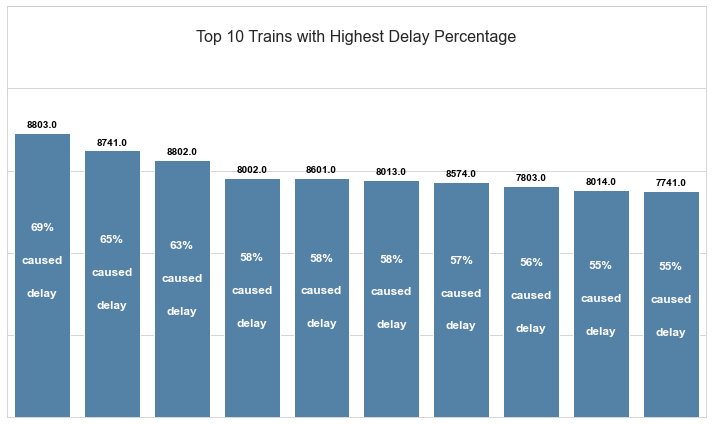

In [1381]:

# Sort the DataFrame by delay_perc in descending order and select the top 10 rows
top_10 = bad.nlargest(10, 'label_perc')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting with Seaborn
sns.set_style('whitegrid')
ax = sns.barplot(x='TRAIN_NUMBER', y='label_perc', data=top_10, color='steelblue', order=top_10['TRAIN_NUMBER'])

# Add rounded percentages to each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 1.5, f'{round(height * 100)}%',
            ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax.text(p.get_x() + p.get_width() / 2, (height / 1.5) - 0.08, 'caused',
            ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax.text(p.get_x() + p.get_width() / 2, (height / 1.5) - 0.16, 'delay',
            ha='center', va='center', color='white', weight='bold', fontsize=12)

# Remove ytick labels
ax.set_yticklabels([])

# Remove xtick labels
ax.set_xticklabels([])

# Add train numbers on top of the bars as black bold patches
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.02, top_10['TRAIN_NUMBER'].iloc[i],
            ha='center', va='center', color='black', weight='bold', fontsize=10)

plt.xlabel('')
plt.ylabel('')

# Set the title and adjust its position
ax.set_title('Top 10 Trains with Highest Delay Percentage', fontsize=16, y=0.9)

plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
plt.tight_layout()
plt.show()

In [45]:
basetable.dtypes.value_counts()

float64    1867
int64         7
object        3
Name: count, dtype: int64

In [47]:
print(basetable['label'].value_counts(normalize=False))
print(basetable['label'].value_counts(normalize=True)[0])
print(basetable['label'].value_counts(normalize=True)[1])

label
0    54186
1     8600
Name: count, dtype: int64
0.8630267894116522
0.13697321058834772


In [51]:

# Split the data into training and testing sets
X = basetable.drop(columns=['label'], axis=1)
y = basetable['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# define the categorical and numeric features to be transformed
cat_cols = ['month', 'day_origin']
numeric_features = ['stations_count']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())


       stations_count
count        43950.00
mean            -0.00
std              1.00
min             -1.96
25%             -0.69
50%             -0.18
75%              0.58
max              3.11


In [52]:
# create dummy variables for categorical features (such as last_family_indep)
X_train_dummies = pd.get_dummies(X_train[cat_cols])
X_train_dummies = X_train_dummies.astype(int) # binary for shap

X_test_dummies = pd.get_dummies(X_test[cat_cols])
X_test_dummies = X_test_dummies.astype(int) # binary for shap

X_test_dummies = X_test_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

# add dummies to train/test, remove original columns
X_train = X_train.drop(columns=cat_cols)
X_train = pd.concat([X_train, X_train_dummies], axis=1)

X_test = X_test.drop(columns=cat_cols)
X_test = pd.concat([X_test, X_test_dummies], axis=1)

# control dataframes
X_train_id_trno = X_train
X_test_id_trno = X_test
X_all_id_trno = pd.concat([X_train, X_test]).reset_index(drop=True)
# remove control columns
X_train = X_train.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID'])
X_test = X_test.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID'])


# check
X_train

,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,morning_rush,stations_count,1015_0_ESSEN,1026_0_1838.0,1064_0_1026.0,1112_0_1003.0,1156_0_959.0,1158_0_GOUVY,1162_0_1169.0,1164_0_1156.0,1166_0_1164.0,1169_0_1166.0,1172_0_787.0,1209_0_631.0,1292_0_735.0,1293_0_803.0,145_0_783.0,145_0_799.0,156_0_787.0,1831_0_1899.0,1838_0_NOORDERKEMPEN,1899_0_1938.0,1899_0_735.0,1915_0_803.0,1933_0_1172.0,1936_0_156.0,1938_0_1292.0,1938_0_735.0,1_0_HERGENRATH,1_0_LIEGE-GUILLEMINS,202_0_1915.0,...,ZINGEM_480_EINE,ZINGEM_755_GAVERE-ASPER,ZOLDER_1134_HEUSDEN,ZOLDER_1134_ZONHOVEN,ZONHOVEN_1134_HASSELT,ZONHOVEN_1134_ZOLDER,ZOTTEGEM_106_BURST,ZOTTEGEM_106_DENDERLEEUW,ZOTTEGEM_106_HERZELE,ZOTTEGEM_106_HILLEGEM,ZOTTEGEM_561_BALEGEM-ZUID,ZOTTEGEM_561_GENT-SINT-PIETERS,ZOTTEGEM_673_LIERDE,ZOTTEGEM_674_MUNKZWALM,ZOTTEGEM_674_OUDENAARDE,ZWIJNDRECHT_1312_ANTWERPEN-ZUID,ZWIJNDRECHT_1312_MELSELE,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,day_origin_Friday,day_origin_Monday,day_origin_Sunday,day_origin_Thursday,day_origin_Tuesday,day_origin_Wednesday
24871,0,0,0,0.394444,1,0.325576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
27561,0,0,0,0.372222,1,-1.702746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11172,0,0,0,0.833333,1,-1.449206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3202,0,0,0,0.444444,1,0.072035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3643,0,0,0,0.316667,0,-0.688585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52978,1,0,0,0.511111,0,-0.942126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
16236,0,0,0,0.283333,1,-1.195666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
43726,1,0,0,0.311111,1,0.832656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
60701,1,0,0,0.372222,1,-1.195666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
X_all_id_trno[X_all_id_trno['TRAIN_NUMBER'] == '8803.0']

In [54]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)

# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([0, 0, 0, ..., 0, 1, 0])

In [55]:
# Initial Model creation (Classification):

desired_pos_weight = math.sqrt(basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1])
# with (basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1]), we achieve precision & recall of .29 & .64 
# with math.sqrt(basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1]), we achieve precision & recall of .42 & .43 

xgbc = XGBClassifier(objective='binary:logistic', seed=42, eta=0.1, n_jobs=8, scale_pos_weight = desired_pos_weight)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])



[0]	validation_0-aucpr:0.35506
[1]	validation_0-aucpr:0.35564
[2]	validation_0-aucpr:0.37824
[3]	validation_0-aucpr:0.37788
[4]	validation_0-aucpr:0.38770
[5]	validation_0-aucpr:0.38974
[6]	validation_0-aucpr:0.39086
[7]	validation_0-aucpr:0.39083
[8]	validation_0-aucpr:0.39674
[9]	validation_0-aucpr:0.39826
[10]	validation_0-aucpr:0.39720
[11]	validation_0-aucpr:0.39760
[12]	validation_0-aucpr:0.39749
[13]	validation_0-aucpr:0.39885
[14]	validation_0-aucpr:0.40076
[15]	validation_0-aucpr:0.40133
[16]	validation_0-aucpr:0.40298
[17]	validation_0-aucpr:0.40295
[18]	validation_0-aucpr:0.40377
[19]	validation_0-aucpr:0.40413
[20]	validation_0-aucpr:0.40612
[21]	validation_0-aucpr:0.40939
[22]	validation_0-aucpr:0.40934
[23]	validation_0-aucpr:0.41235
[24]	validation_0-aucpr:0.41268
[25]	validation_0-aucpr:0.41460
[26]	validation_0-aucpr:0.41451
[27]	validation_0-aucpr:0.41516
[28]	validation_0-aucpr:0.41621
[29]	validation_0-aucpr:0.41659
[30]	validation_0-aucpr:0.41684
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, predictor=None, ...)

In [845]:
# make random predictions for the test set, according to weights
#y_pred = np.random.choice([0, 1], size=(len(y_test),), p=[1 - basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight, basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight])

In [56]:

# initial Model evaluation
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)
#y_pred = np.random.choice([0, 1], size=(len(y_test),), p=[1 - basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight, basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight])

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

# calc balanced accurcary
print('balanced accuracy score:', round(balanced_accuracy_score(y_test, y_pred),2))

# calc balanced precision
print('balanced precision score:', round(precision_score(y_test, y_pred, average='weighted'),4))

# calc balanced recall
print('balanced recall score:', round(recall_score(y_test, y_pred, average='weighted'),4))

Accuracy: 0.86
Precision: 0.48
Recall: 0.47
F1 score: 0.47
 - - - 
AUC score: 0.81
classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     16256
           1       0.48      0.47      0.47      2580

    accuracy                           0.86     18836
   macro avg       0.70      0.69      0.70     18836
weighted avg       0.86      0.86      0.86     18836

balanced accuracy score: 0.69
balanced precision score: 0.8559
balanced recall score: 0.8573


In [57]:
# grid search

# round 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, desired_pos_weight, 5]
}

# for speed-up and avoiding overfitting we use a random subset of the data (90%) and a
# random subset of the features (50%) per tree
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)
# best found: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.7083275299850995}

/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in c

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.7083275299850995}


In [814]:
# Tuned Model creation:

xgbc = XGBClassifier(objective='binary:logistic',
                     seed=42,
                     eta=0.1,
                     max_depth=5,
                     gamma=1,
                     reg_lambda=1,
                     scale_pos_weight = desired_pos_weight,
                     subsample=0.9,
                     colsample_bytree=0.5,
                     n_jobs=10)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=False,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=10,
              num_parallel_tree=None, predictor=None, ...)

In [738]:

# Model evaluation
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.85
Precision: 0.46
Recall: 0.48
F1 score: 0.47
 - - - 
AUC score: 0.8
classification report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     16256
           1       0.46      0.48      0.47      2580

    accuracy                           0.85     18836
   macro avg       0.69      0.69      0.69     18836
weighted avg       0.85      0.85      0.85     18836



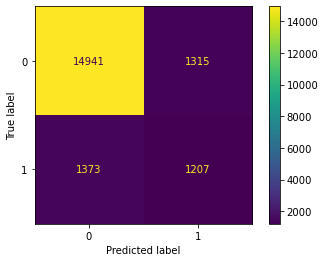

In [57]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbc.classes_)
disp.plot()

In [58]:
# Feature importances:

importances = xgbc.feature_importances_


sorted_indices = np.argsort(importances)[::-1][:10]
 


indices = importances.argsort()[::-1][:10] # get the indices of the top 10 most important features
for i in indices:
    print(f"{i+1}. {X_train.columns[i]}: {round(importances[i], 2)}")
#fig, ax = plt.subplots(figsize=(20, 14)) 
#plt.title('Feature Importance')
#plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
#plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
#plt.tight_layout()
#plt.show()

1573. SCHAARBEEK_1354_BRUSSEL-NOORD: 0.15000000596046448
1571. SCHAARBEEK_1350_BRUSSEL-NOORD: 0.09000000357627869
355. BRUSSEL-CENTRAAL_1435_BRUSSEL-NOORD: 0.03999999910593033
351. BRUSSEL-CENTRAAL_1432_BRUSSEL-ZUID: 0.03999999910593033
407. BRUSSEL-SCHUMAN_1598_BRUSSEL-LUXEMBURG: 0.03999999910593033
352. BRUSSEL-CENTRAAL_1433_BRUSSEL-NOORD: 0.029999999329447746
350. BRUSSEL-CENTRAAL_1431_BRUSSEL-NOORD: 0.029999999329447746
357. BRUSSEL-CENTRAAL_1436_BRUSSEL-ZUID: 0.029999999329447746
353. BRUSSEL-CENTRAAL_1434_BRUSSEL-ZUID: 0.019999999552965164
6. stations_count: 0.019999999552965164


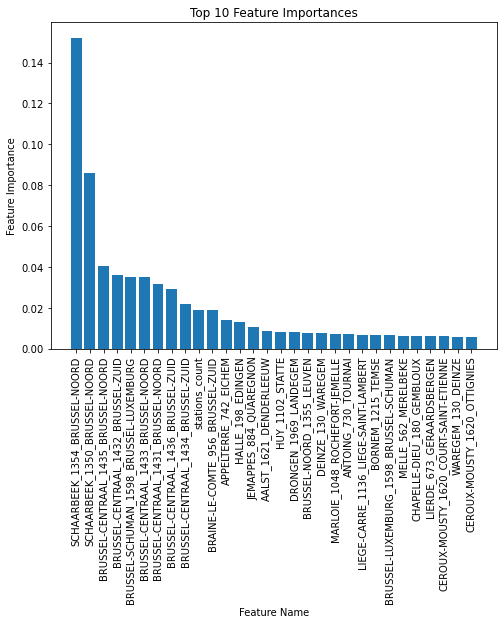

In [59]:
# Get feature importances and sort them in descending order
importances = xgbc.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top 30 features
top_indices = indices[:30]
top_importances = importances[top_indices]

# Get the corresponding feature names
feature_names = X_train.columns
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the top 30 features and their importances
plt.figure(figsize=(8,6))
plt.bar(range(len(top_importances)), top_importances)
plt.xticks(range(len(top_importances)), top_feature_names, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()

In [60]:
# Create an explainer object for the random forest classifier
tree_explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = tree_explainer.shap_values(X_test)

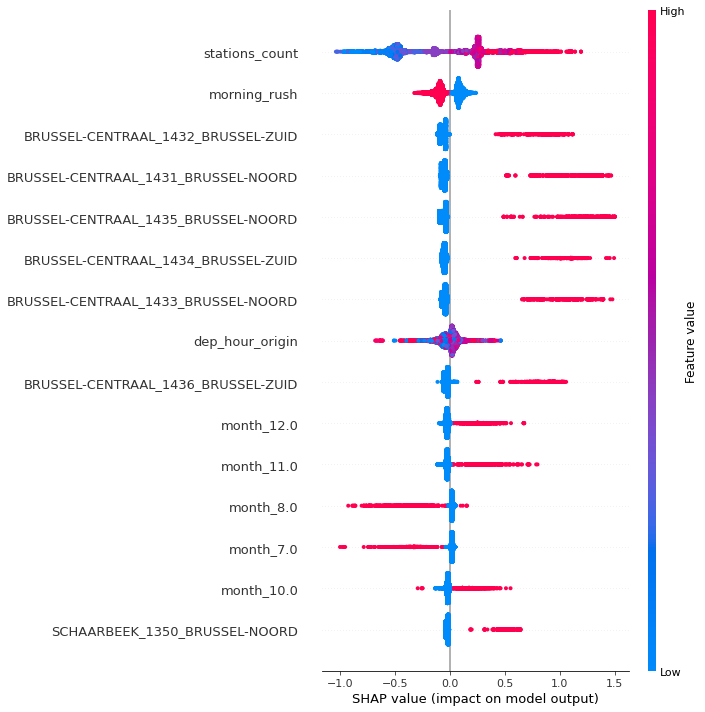

<Figure size 432x288 with 0 Axes>

In [61]:
# get summary plot
shap.summary_plot(shap_values, X_test, max_display=15, plot_size=(10, 10))

plt.tight_layout()

In [1036]:
# Reduce candidate number of features with shap values

# write function to do feature selection based on shap values
def feature_selection_shap(model, X, y, threshold):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    shap_abs_mean_df = pd.DataFrame(list(zip(X.columns, shap_abs_mean)), columns=['feature','shap_abs_mean'])
    shap_abs_mean_df.sort_values(by=['shap_abs_mean'], ascending=False, inplace=True)
    shap_abs_mean_df.reset_index(drop=True, inplace=True)
    shap_abs_mean_df['cum_sum'] = shap_abs_mean_df['shap_abs_mean'].cumsum()
    shap_abs_mean_df['cum_perc'] = 100*shap_abs_mean_df['cum_sum']/shap_abs_mean_df['shap_abs_mean'].sum()
    shap_abs_mean_df = shap_abs_mean_df[shap_abs_mean_df['cum_perc'] <= threshold]
    return shap_abs_mean_df

# get feature selection df
shap_abs_mean_df = feature_selection_shap(xgbc, X_train, y_train, 95)

# get list of selected features
selected_candidate_features = shap_abs_mean_df['feature'].tolist()

# check
shap_abs_mean_df


KeyboardInterrupt: 

In [129]:
# Borutashap to further reduce features
selector = BorutaShap(importance_measure='shap', classification=True)

# Fit the selector
selector.fit(X=X_train[selected_candidate_features], y=y_train, n_trials=100,
             random_state=42, sample=False, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

## Explanation of observed: Force Plots

In [1227]:
X_expl_chosen.head(5)

,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,morning_rush,stations_count,times_ahead,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,day_origin_Friday,day_origin_Monday,day_origin_Sunday,day_origin_Thursday,day_origin_Tuesday,day_origin_Wednesday
38380,0,0,0,0.433333,0,1.593277,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32972,0,0,0,0.433333,0,1.593277,4.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61509,1,0,0,0.433333,0,1.593277,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2409,0,0,0,0.433333,0,1.593277,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
20026,0,0,0,0.433333,0,1.593277,4.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
# get columns of the model, and train number we want to explain
pure_features = X_train.columns.tolist()
X_expl_chosen = X_test_id_trno[X_test_id_trno['TRAIN_NUMBER'] == '8803.0'][pure_features]
synthetic_example = X_expl_chosen.iloc[0].values

In [1247]:
X_expl_chosen.head(5)

,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,morning_rush,stations_count,times_ahead,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,day_origin_Friday,day_origin_Monday,day_origin_Sunday,day_origin_Thursday,day_origin_Tuesday,day_origin_Wednesday
38380,0,0,0,0.433333,0,1.593277,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32972,0,0,0,0.433333,0,1.593277,4.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61509,1,0,0,0.433333,0,1.593277,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2409,0,0,0,0.433333,0,1.593277,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
20026,0,0,0,0.433333,0,1.593277,4.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [1230]:

# example array of predicted probabilities
# find the indexes of the ten highest and lowest values
top_indexes = y_pred_proba.argsort()[-10:][::-1]
bottom_indexes = y_pred_proba.argsort()[:10]

print("Indexes of top 10 values:", top_indexes)
print("Indexes of bottom 10 values:", bottom_indexes)



Indexes of top 10 values: [14722 18378  3713  2601   974  8012  5580  6870 17031   385]
Indexes of bottom 10 values: [14638 16275  3442  5616 16552  1363  8874  8136 13968  8357]


In [1232]:
# high example
print(y_test[top_indexes[1]])
shap.force_plot(explainer.expected_value, shap_values[top_indexes[1],:], X_test.iloc[top_indexes[1],:], link="logit")

KeyError: 18378

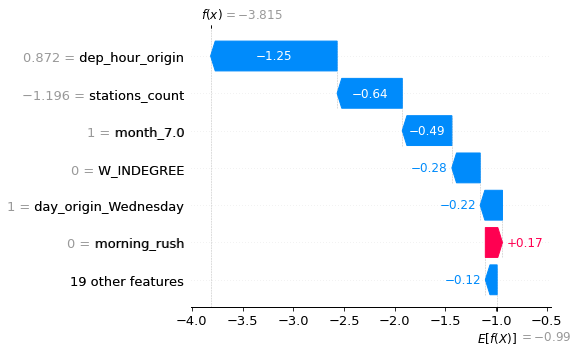

In [1044]:
# plot waterfall plot with legend of feature names and values
explainer2 = shap.Explainer(xgbc, X_test)
shap_values2 = explainer(X_test)

shap.plots.waterfall(shap_values2[bottom_indexes[1],:], max_display=7, show=False)
plt.tight_layout()

In [1005]:
# low example
print(y_test[bottom_indexes[1]])
shap.force_plot(explainer.expected_value, shap_values[bottom_indexes[1],:], X_test.iloc[bottom_indexes[1],:], link="logit")


KeyError: 8874

In [113]:
# random example
print(y_test[123])
shap.force_plot(explainer.expected_value, shap_values[123,:], X_test.iloc[123,:], link="logit")

0


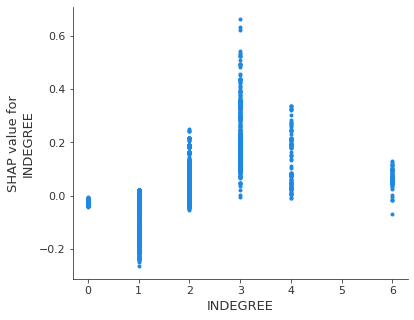

In [522]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(X_test.columns.get_loc('INDEGREE'), shap_values, X_test, interaction_index=None)

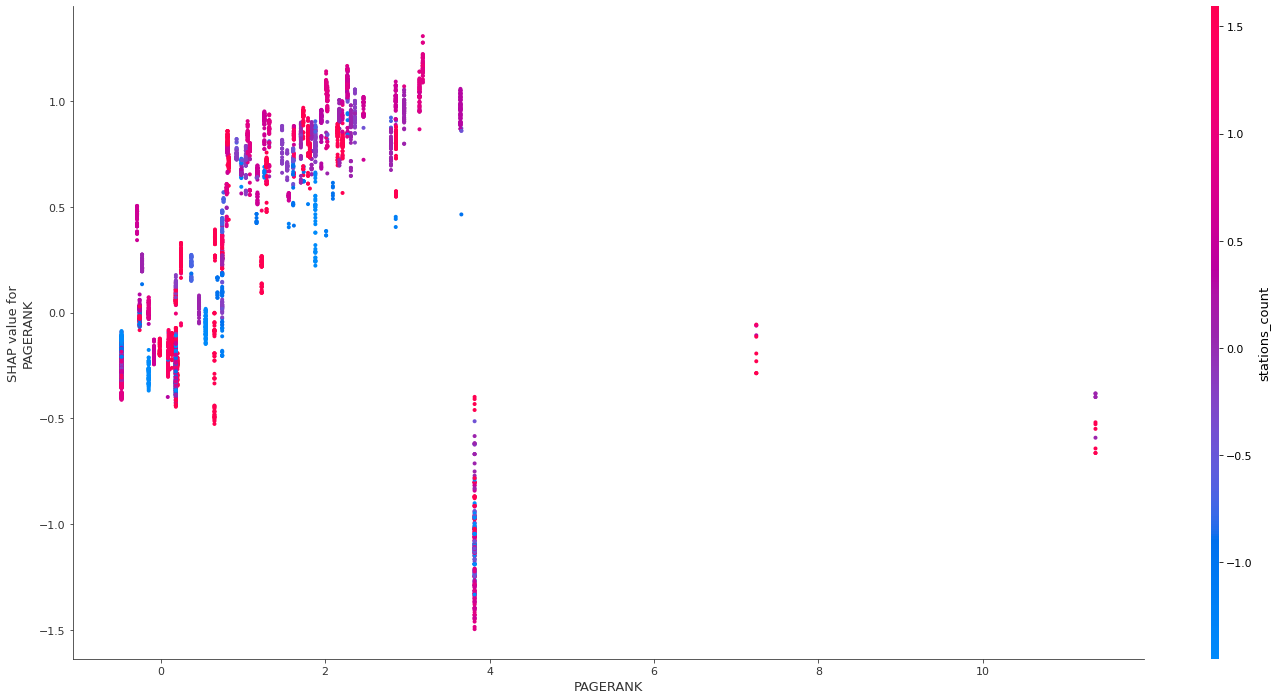

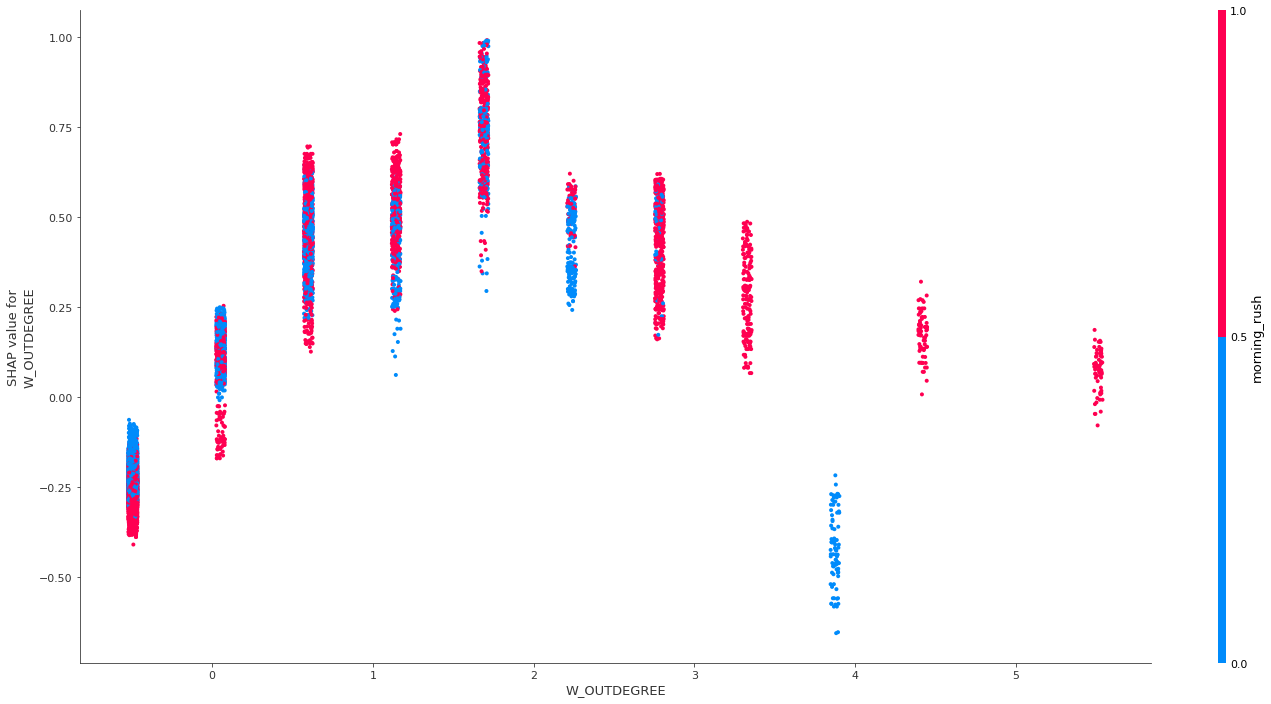

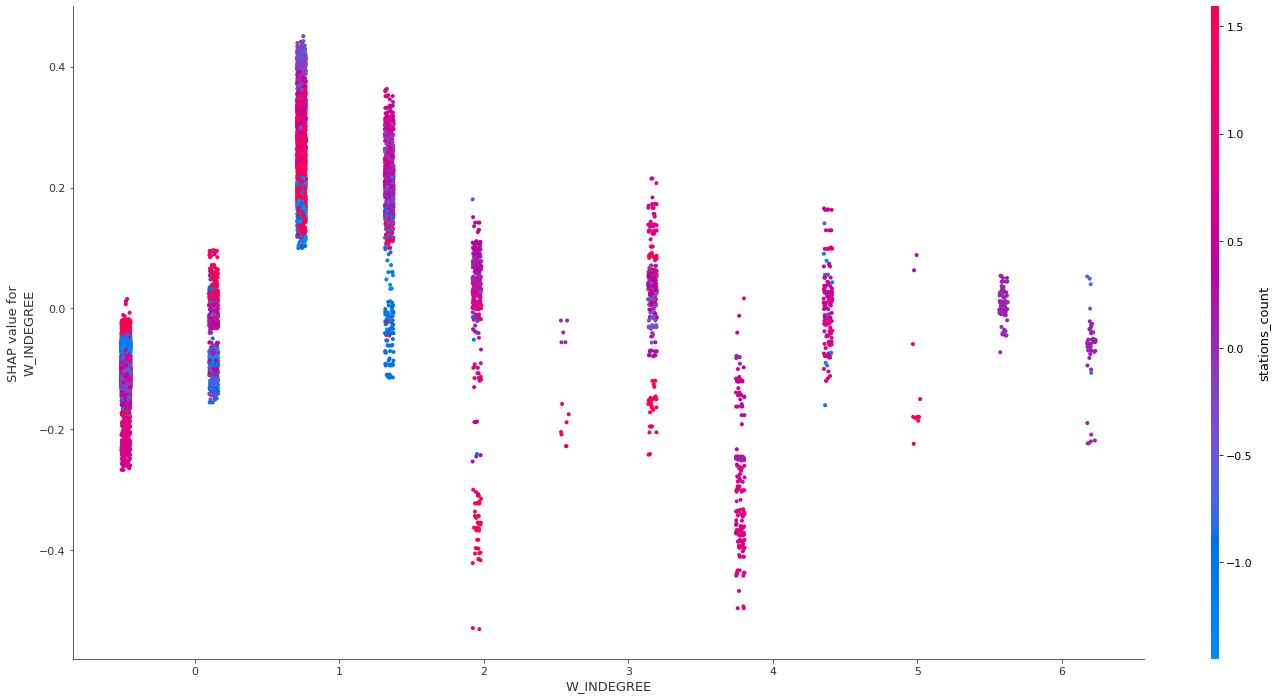

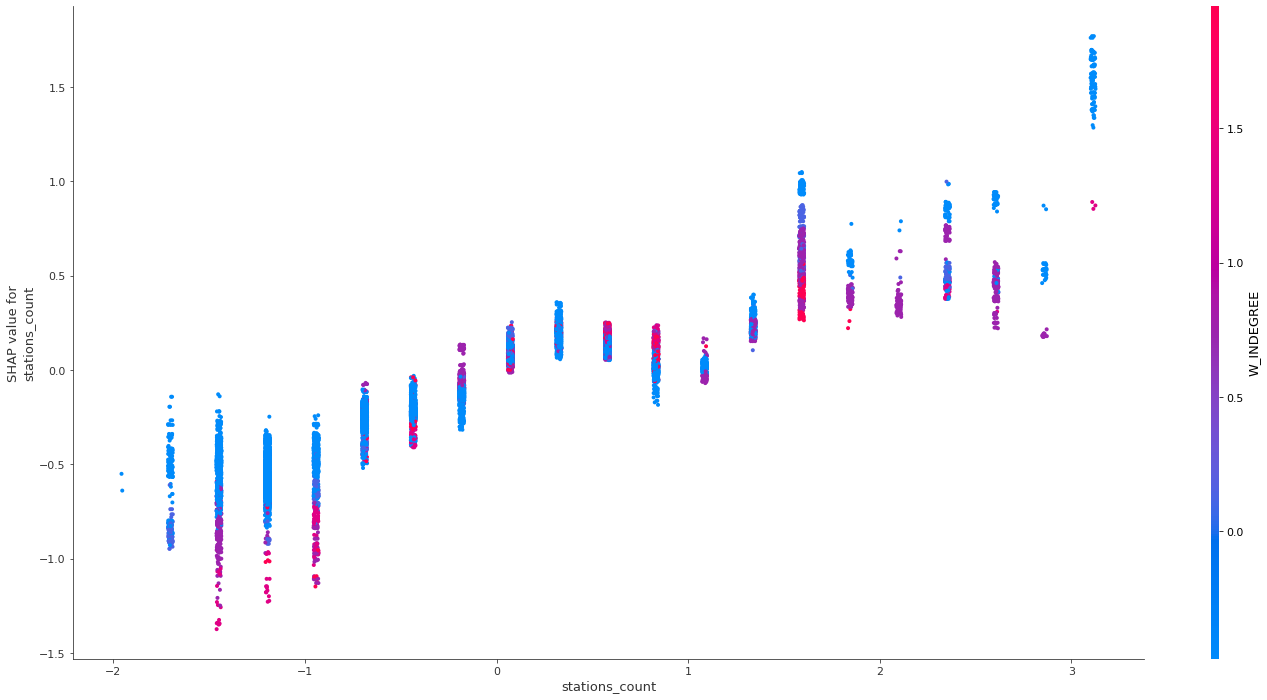

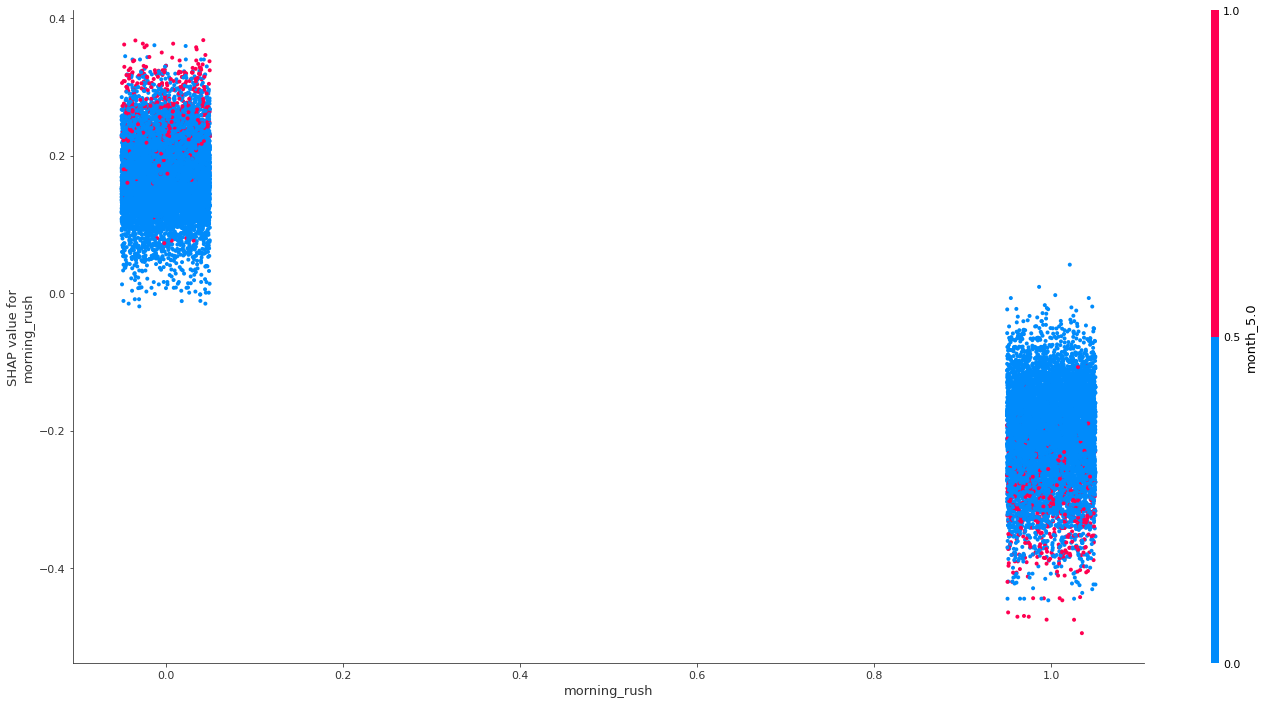

In [119]:
# check shap and interaction effects
shap_values = explainer.shap_values(X_test)
for feat_name in  X_train.columns[sorted_indices][:5]:
    shap.dependence_plot(f"{feat_name}", shap_values, X_test, show = False, x_jitter = .1)

    plt.gcf().set_size_inches(24, 12)
    # Show the plot
    plt.show()